In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("neural_activity_with_target.csv", engine='python', on_bad_lines='skip')

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        if isinstance(val, float) or isinstance(val, int):
            return [val]
        elif isinstance(val, str):
            return [0.0]
        else:
            return [0.0]

df['Parsed_Signal'] = df['Raw_Signal'].apply(safe_literal_eval)

min_len = 16
df['Parsed_Signal'] = df['Parsed_Signal'].apply(lambda x: x + [0.0] * (max(min_len, len(x)) - len(x)))

X = np.array(df['Parsed_Signal'].tolist(), dtype=np.float32)
y = df['Target'].values.astype(np.int64)

X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
X = X[:, np.newaxis, :]  # (N, 1, L)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

class EEGConvLSTM(nn.Module):
    def __init__(self, input_len, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2,
                            batch_first=True, dropout=0.3, bidirectional=False)

        self.dropout_fc = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128, 64)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.act(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(self.act(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool3(self.act(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        x = x.contiguous().permute(0, 2, 1)  # (batch, seq_len, features)

        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep output

        out = self.dropout_fc(out)
        out = self.act(self.fc1(out))
        out = self.fc2(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGConvLSTM(input_len=X.shape[2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    torch.cuda.empty_cache()  # optional GPU memory cleanup

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        print(predicted,batch_y)
        correct += (predicted == batch_y).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")


Epoch 1/100, Loss: 13.8843
Epoch 2/100, Loss: 13.8295
Epoch 3/100, Loss: 13.7799
Epoch 4/100, Loss: 13.6409
Epoch 5/100, Loss: 13.4282
Epoch 6/100, Loss: 13.2840
Epoch 7/100, Loss: 13.2838
Epoch 8/100, Loss: 13.3753
Epoch 9/100, Loss: 13.0086
Epoch 10/100, Loss: 12.5709
Epoch 11/100, Loss: 12.6688
Epoch 12/100, Loss: 12.7625
Epoch 13/100, Loss: 12.4113
Epoch 14/100, Loss: 11.8772
Epoch 15/100, Loss: 12.0983
Epoch 16/100, Loss: 11.9500
Epoch 17/100, Loss: 11.7194
Epoch 18/100, Loss: 11.5518
Epoch 19/100, Loss: 11.4486
Epoch 20/100, Loss: 11.3841
Epoch 21/100, Loss: 11.2728
Epoch 22/100, Loss: 10.8701
Epoch 23/100, Loss: 11.0732
Epoch 24/100, Loss: 11.2404
Epoch 25/100, Loss: 10.3736
Epoch 26/100, Loss: 10.9185
Epoch 27/100, Loss: 9.9882
Epoch 28/100, Loss: 10.4179
Epoch 29/100, Loss: 9.7180
Epoch 30/100, Loss: 9.4911
Epoch 31/100, Loss: 9.5462
Epoch 32/100, Loss: 10.3779
Epoch 33/100, Loss: 10.0860
Epoch 34/100, Loss: 10.0306
Epoch 35/100, Loss: 8.6853
Epoch 36/100, Loss: 8.5243
Epoch 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("neural_activity_with_target.csv", quoting=csv.QUOTE_NONE, engine='python', on_bad_lines='skip')

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        if isinstance(val, float) or isinstance(val, int):
            return [val]
        elif isinstance(val, str):
            return [0.0]
        else:
            return [0.0]

df['Parsed_Signal'] = df['Raw_Signal'].apply(safe_literal_eval)

min_len = 16
df['Parsed_Signal'] = df['Parsed_Signal'].apply(lambda x: x + [0.0] * (max(min_len, len(x)) - len(x)))

X = np.array(df['Parsed_Signal'].tolist(), dtype=np.float32)
y = df['Target'].values.astype(np.int64)

X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
X = X[:, np.newaxis, :]  # (N, 1, L)

from collections import Counter

# Count class frequencies
class_counts = Counter(y)

# Keep only classes with at least 2 samples
valid_classes = [cls for cls, count in class_counts.items() if count >= 2]
mask = np.isin(y, valid_classes)

X = X[mask]
y = y[mask]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

class EEGConvLSTM(nn.Module):
    def __init__(self, input_len, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=2, batch_first=True, dropout=0.3)
        self.dropout_fc = nn.Dropout(0.4)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = x.contiguous().permute(0, 2, 1)  # (batch, seq_len, features)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.dropout_fc(out)
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGConvLSTM(input_len=X.shape[2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    torch.cuda.empty_cache()  # optional GPU memory cleanup

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        print(predicted,batch_y)
        correct += (predicted == batch_y).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")


Epoch 1/100, Loss: 13.5312
Epoch 2/100, Loss: 11.9360
Epoch 3/100, Loss: 8.9230
Epoch 4/100, Loss: 7.4585
Epoch 5/100, Loss: 6.9261
Epoch 6/100, Loss: 6.8811
Epoch 7/100, Loss: 7.1563
Epoch 8/100, Loss: 7.0586
Epoch 9/100, Loss: 7.0354
Epoch 10/100, Loss: 6.9971
Epoch 11/100, Loss: 6.7791
Epoch 12/100, Loss: 6.6258
Epoch 13/100, Loss: 7.2894
Epoch 14/100, Loss: 6.6807
Epoch 15/100, Loss: 6.6560
Epoch 16/100, Loss: 7.0904
Epoch 17/100, Loss: 6.7405
Epoch 18/100, Loss: 6.9007
Epoch 19/100, Loss: 6.7035
Epoch 20/100, Loss: 6.7637
Epoch 21/100, Loss: 7.0360
Epoch 22/100, Loss: 6.7620
Epoch 23/100, Loss: 6.9153
Epoch 24/100, Loss: 6.8765
Epoch 25/100, Loss: 6.4927
Epoch 26/100, Loss: 6.9972
Epoch 27/100, Loss: 6.6552
Epoch 28/100, Loss: 6.5180
Epoch 29/100, Loss: 6.9270
Epoch 30/100, Loss: 6.6848
Epoch 31/100, Loss: 6.8223
Epoch 32/100, Loss: 6.6982
Epoch 33/100, Loss: 6.8730
Epoch 34/100, Loss: 6.4073
Epoch 35/100, Loss: 6.7581
Epoch 36/100, Loss: 6.9996
Epoch 37/100, Loss: 6.7037
Epoch 38

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("neural_activity_with_target.csv", engine='python', on_bad_lines='skip')

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        if isinstance(val, (float, int)):
            return [val]
        elif isinstance(val, str):
            return [0.0]
        else:
            return [0.0]

# Downsample function to convert signal to target length
def downsample_signal(signal, target_length=65):
    signal = np.array(signal)
    original_length = len(signal)
    if original_length == target_length:
        return signal
    indices = np.linspace(0, original_length - 1, target_length).astype(int)
    return signal[indices]

# Set target length (matches Magnitude and Phase length)
target_len = 65

# Parse and downsample Raw_Signal
df['Parsed_Signal'] = df['Raw_Signal'].apply(safe_literal_eval)
df['Parsed_Signal'] = df['Parsed_Signal'].apply(lambda x: downsample_signal(x, target_len))

# Parse and pad Magnitude and Phase
df['Parsed_Magnitude'] = df['Magnitude'].apply(safe_literal_eval)
df['Parsed_Magnitude'] = df['Parsed_Magnitude'].apply(lambda x: x + [0.0] * (target_len - len(x)))

df['Parsed_Phase'] = df['Phase'].apply(safe_literal_eval)
df['Parsed_Phase'] = df['Parsed_Phase'].apply(lambda x: x + [0.0] * (target_len - len(x)))

# Debug lengths (optional)
print("Lengths Raw_Signal:", df['Parsed_Signal'].apply(len).unique())
print("Lengths Magnitude:", df['Parsed_Magnitude'].apply(len).unique())
print("Lengths Phase:", df['Parsed_Phase'].apply(len).unique())

# Convert to numpy arrays
X_signal = np.array(df['Parsed_Signal'].tolist(), dtype=np.float32)
X_magnitude = np.array(df['Parsed_Magnitude'].tolist(), dtype=np.float32)
X_phase = np.array(df['Parsed_Phase'].tolist(), dtype=np.float32)

# Normalize each channel separately (per sample)
def normalize_channel(x):
    mean = x.mean(axis=1, keepdims=True)
    std = x.std(axis=1, keepdims=True) + 1e-8
    return (x - mean) / std

X_signal = normalize_channel(X_signal)
X_magnitude = normalize_channel(X_magnitude)
X_phase = normalize_channel(X_phase)

# Stack channels: shape (N, 3, length)
X = np.stack([X_signal, X_magnitude, X_phase], axis=1)

y = df['Target'].values.astype(np.int64)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Prepare datasets and loaders
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Model with 3 input channels
class EEGConvLSTM(nn.Module):
    def __init__(self, input_len, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=3, padding=1)  # 3 input channels now
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2,
                            batch_first=True, dropout=0.3, bidirectional=False)

        self.dropout_fc = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128, 64)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.act(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(self.act(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool3(self.act(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        x = x.contiguous().permute(0, 2, 1)  # (batch, seq_len, features)

        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep output

        out = self.dropout_fc(out)
        out = self.act(self.fc1(out))
        out = self.fc2(out)
        return out

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGConvLSTM(input_len=X.shape[2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    torch.cuda.empty_cache()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")


Lengths Raw_Signal: [65]
Lengths Magnitude: [65]
Lengths Phase: [65]


ValueError: all input arrays must have the same shape

In [ ]:
len(X_train)

80

In [ ]:
print(np.unique(y))


[0 1 2 3]


In [ ]:
print(df.columns)

Index(['Patient_ID', 'Age', 'Gender', 'Clinical_Stage', 'Condition_Label',
       'Target', 'Raw_Signal', 'Magnitude', 'Phase', 'Parsed_Signal',
       'Parsed_Magnitude', 'Parsed_Phase'],
      dtype='object')


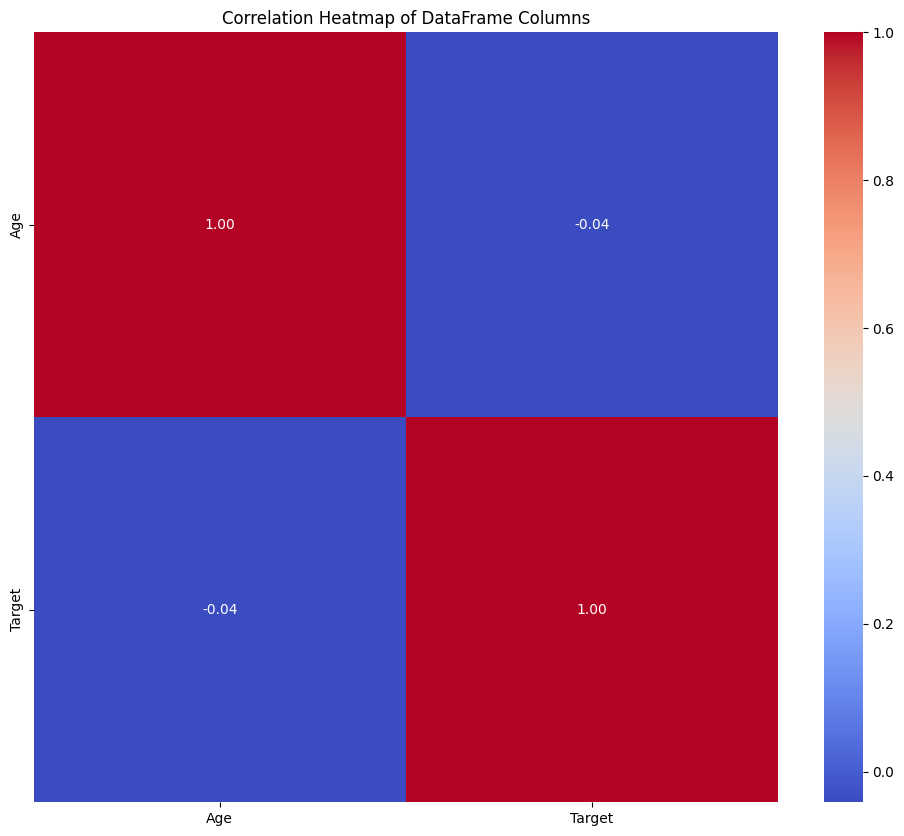

In [ ]:
# prompt: heat map for the df dataframe

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the numerical columns for correlation
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [5]:
df = pd.read_csv('pd_EEG_features.csv')
df.head()

,id,gender,PPE,EEG,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,...,0.071728,0.010352,-2.73030,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363615,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,...,0.729330,0.780410,5.22940,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,...,0.269510,-0.005522,0.35054,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.17295,0.147370,...,0.366920,-0.492650,0.19164,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.2531,3.0295,2.0362,1.8478,2.5776,2.2064,1.9491,1.9120,1.8829,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.3

In [ ]:
df.columns

Index(['id', 'gender', 'PPE', 'EEG', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=755)

In [6]:
df.drop_duplicates(keep='first',inplace=True)

In [7]:
df.isnull().sum().sum()

np.int64(0)

In [8]:
df.shape

(755, 755)

In [11]:
print(len(df[df['class']==0]))

192


In [10]:
df.dropna(inplace=True,axis=0)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,recall_score,precision_score,f1_score,roc_auc_score
import numpy as np

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
np.mean(X_train), np.std(X_train), np.mean(X_test), np.std(X_test)

(np.float64(2.4603868362127266e-17),
 np.float64(0.9999999999999999),
 np.float64(0.01167461003001191),
 np.float64(1.0887825910983278))

In [15]:
feature_names = X.columns.tolist()

# Function to print top N features contributing to each PC
def print_top_features(pca, feature_names, top_n=5):
    for i, component in enumerate(pca.components_):
        print(f"\nTop {top_n} features contributing to Principal Component {i+1}:")
        # Get indices of features sorted by absolute loading descending
        top_indices = np.argsort(np.abs(component))[::-1][:top_n]
        for idx in top_indices:
            print(f"{feature_names[idx]}: loading {component[idx]:.4f}")

# Print top 5 features per component
print_top_features(my_PCA, feature_names, top_n=55)


Top 55 features contributing to Principal Component 1:
app_LT_entropy_shannon_6_coef: loading 0.0820
app_LT_TKEO_mean_10_coef: loading -0.0819
app_LT_entropy_shannon_5_coef: loading 0.0819
app_LT_TKEO_std_10_coef: loading -0.0819
app_LT_entropy_shannon_7_coef: loading 0.0819
app_LT_TKEO_std_9_coef: loading -0.0819
app_LT_TKEO_mean_9_coef: loading -0.0818
app_LT_TKEO_mean_8_coef: loading -0.0818
app_LT_entropy_shannon_10_coef: loading 0.0817
app_LT_entropy_shannon_8_coef: loading 0.0817
app_LT_entropy_shannon_9_coef: loading 0.0817
app_LT_TKEO_std_7_coef: loading -0.0815
app_LT_TKEO_std_8_coef: loading -0.0814
app_LT_entropy_shannon_4_coef: loading 0.0813
app_LT_entropy_log_8_coef: loading -0.0812
app_LT_entropy_log_9_coef: loading -0.0812
app_LT_entropy_log_10_coef: loading -0.0812
app_LT_TKEO_mean_7_coef: loading -0.0811
app_entropy_log_8_coef: loading -0.0810
app_entropy_log_9_coef: loading -0.0810
app_entropy_log_10_coef: loading -0.0810
app_entropy_log_7_coef: loading -0.0808
app_

In [14]:
my_PCA = PCA(n_components=2)
X_train_pca = my_PCA.fit_transform(X_train)
X_test_pca = my_PCA.transform(X_test)


my_PCA = PCA(0.8)
X_train_pca = my_PCA.fit_transform(X_train)
X_test_pca = my_PCA.transform(X_test)


In [16]:
log_model = LogisticRegression()
log_model.fit(X_train_pca, y_train)
predictions = log_model.predict(X_test_pca)

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions, labels = [1,0]))
print(recall_score(y_test, predictions))
print(precision_score(y_test, predictions))
print(f1_score(y_test, predictions))
print(roc_auc_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.63      0.73        54
           1       0.87      0.96      0.91       135

    accuracy                           0.87       189
   macro avg       0.87      0.80      0.82       189
weighted avg       0.87      0.87      0.86       189

[[130   5]
 [ 20  34]]
0.9629629629629629
0.8666666666666667
0.9122807017543859
0.7962962962962963


In [ ]:
# prompt: logistic regression for multi variant

# Prepare data for Logistic Regression
# Reshape the 3D array X_train and X_test into 2D arrays for Logistic Regression
# The dimensions are (Number of samples, Number of channels * Length of signal)


# Train Logistic Regression model
log_model = LogisticRegression(multi_class='auto', solver='liblinear') # 'auto' handles binary and multi-class
log_model.fit(X_train_pca, y_train)

# Make predictions
predictions = log_model.predict(X_test_pca)
predictions_proba = log_model.predict_proba(X_test_pca)

# Evaluate the model
print("\nLogistic Regression Results:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

# For multi-class, ROC AUC score is usually calculated on a per-class or averaged basis
# Using 'ovo' (one-vs-one) or 'ovr' (one-vs-rest) for multi-class AUC
# Using 'ovr' as it's more common

from sklearn.metrics import roc_auc_score

# y_test_labels is the true label vector (1D)
# predictions_proba is the predicted probabilities, shape (n_samples, n_classes)

roc_auc = roc_auc_score(y_test, predictions_proba, multi_class='ovr')  # For multi-class
print(f"ROC AUC Score (OVR): {roc_auc:.4f}")

# For multi-class, recall, precision, f1 score need to specify averaging method
# Using 'weighted' average as it accounts for class imbalance
print("Recall Score (weighted):", recall_score(y_test, predictions, average='weighted'))
print("Precision Score (weighted):", precision_score(y_test, predictions, average='weighted'))
print("F1 Score (weighted):", f1_score(y_test, predictions, average='weighted'))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73        54
           1       0.87      0.96      0.91       135

    accuracy                           0.87       189
   macro avg       0.87      0.80      0.82       189
weighted avg       0.87      0.87      0.86       189

Confusion Matrix:
 [[ 34  20]
 [  5 130]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


ValueError: y should be a 1d array, got an array of shape (189, 2) instead.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode ='min', verbose=1, patience=15)

model = Sequential()
model.add(Dense(150, activation = 'relu'))
model.add(Dense(75, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'adam')

model.fit(x=X_train_pca, y=y_train, epochs=600, validation_data = (X_test_pca, y_test), callbacks=[early_stop])

Epoch 1/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5948 - val_loss: 0.4483
Epoch 2/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3222 - val_loss: 0.4086
Epoch 3/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2836 - val_loss: 0.3656
Epoch 4/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2081 - val_loss: 0.3470
Epoch 5/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1686 - val_loss: 0.3325
Epoch 6/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1631 - val_loss: 0.3234
Epoch 7/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1201 - val_loss: 0.3140
Epoch 8/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0838 - val_loss: 0.3308
Epoch 9/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0840 - val_loss: 0.3163
Epoch 10/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0541 - val_loss: 0.3048
Epoch 11/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0464 - val_loss: 0.2912
Epoch 12/600
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

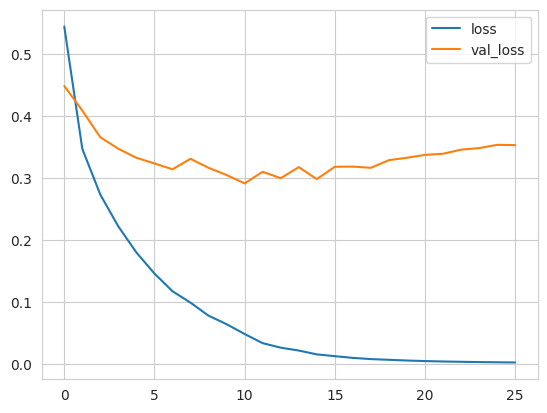

In [ ]:
losses = pd.DataFrame(model.history.history).plot()

In [ ]:
predict = (model.predict(X_test_pca)>0.5).astype('int32')
print(classification_report(y_test, predict))
print(confusion_matrix(y_test, predict, labels = [1,0]))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        54
           1       0.90      0.96      0.93       135

    accuracy                           0.89       189
   macro avg       0.89      0.85      0.86       189
weighted avg       0.89      0.89      0.89       189

[[129   6]
 [ 14  40]]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# ✅ Ensure y_train and y_test are numpy arrays
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.float32).unsqueeze(1)

# Dataset and DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# ✅ ANN Model (equivalent to Keras Sequential model)
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train_pca.shape[1], 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Linear(150, 75),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Linear(75, 25),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.net(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping settings
patience = 15
best_loss = float('inf')
epochs_no_improve = 0
n_epochs = 600

# Training loop with early stopping
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set with more metrics
with torch.no_grad():
    test_preds_prob = model(X_test_tensor.to(device)).cpu().numpy()
    test_preds = (test_preds_prob > 0.5).astype(int)
    y_true = y_test_tensor.numpy()

    accuracy = accuracy_score(y_true, test_preds)
    precision = precision_score(y_true, test_preds)
    recall = recall_score(y_true, test_preds)
    f1 = f1_score(y_true, test_preds)

    # ROC AUC requires probabilities and binary labels
    roc_auc = roc_auc_score(y_true, test_preds_prob)

    print(f"\n✅ Final Test Metrics:")
    print(f"Accuracy:  {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")



Epoch 1/600, Train Loss: 0.5928, Val Loss: 0.5941
Epoch 2/600, Train Loss: 0.4653, Val Loss: 0.4651
Epoch 3/600, Train Loss: 0.3989, Val Loss: 0.4153
Epoch 4/600, Train Loss: 0.3471, Val Loss: 0.3831
Epoch 5/600, Train Loss: 0.3153, Val Loss: 0.3652
Epoch 6/600, Train Loss: 0.2654, Val Loss: 0.3442
Epoch 7/600, Train Loss: 0.2226, Val Loss: 0.3257
Epoch 8/600, Train Loss: 0.1911, Val Loss: 0.3221
Epoch 9/600, Train Loss: 0.1696, Val Loss: 0.3011
Epoch 10/600, Train Loss: 0.1394, Val Loss: 0.3059
Epoch 11/600, Train Loss: 0.1344, Val Loss: 0.2827
Epoch 12/600, Train Loss: 0.1124, Val Loss: 0.2936
Epoch 13/600, Train Loss: 0.0992, Val Loss: 0.2895
Epoch 14/600, Train Loss: 0.0941, Val Loss: 0.2822
Epoch 15/600, Train Loss: 0.0734, Val Loss: 0.2498
Epoch 16/600, Train Loss: 0.0718, Val Loss: 0.2915
Epoch 17/600, Train Loss: 0.0541, Val Loss: 0.2543
Epoch 18/600, Train Loss: 0.0483, Val Loss: 0.2533
Epoch 19/600, Train Loss: 0.0505, Val Loss: 0.2785
Epoch 20/600, Train Loss: 0.0431, Val Lo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# ✅ Ensure y_train and y_test are numpy arrays
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.float32).unsqueeze(1)

# Dataset and DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# ✅ ANN Model (equivalent to Keras Sequential model)
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train_pca.shape[1], 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Linear(150, 75),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Linear(75, 25),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            nn.Linear(25,5),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.net(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping settings
patience = 15
best_loss = float('inf')
epochs_no_improve = 0
n_epochs = 600

# Training loop with early stopping
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set with more metrics
with torch.no_grad():
    test_preds_prob = model(X_test_tensor.to(device)).cpu().numpy()
    test_preds = (test_preds_prob > 0.5).astype(int)
    y_true = y_test_tensor.numpy()

    accuracy = accuracy_score(y_true, test_preds)
    precision = precision_score(y_true, test_preds)
    recall = recall_score(y_true, test_preds)
    f1 = f1_score(y_true, test_preds)

    # ROC AUC requires probabilities and binary labels
    roc_auc = roc_auc_score(y_true, test_preds_prob)

    print(f"\n✅ Final Test Metrics:")
    print(f"Accuracy:  {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")



Epoch 1/600, Train Loss: 0.6341, Val Loss: 0.6027
Epoch 2/600, Train Loss: 0.5553, Val Loss: 0.5595
Epoch 3/600, Train Loss: 0.5159, Val Loss: 0.5407
Epoch 4/600, Train Loss: 0.4914, Val Loss: 0.5187
Epoch 5/600, Train Loss: 0.4704, Val Loss: 0.5138
Epoch 6/600, Train Loss: 0.4576, Val Loss: 0.4887
Epoch 7/600, Train Loss: 0.4304, Val Loss: 0.4940
Epoch 8/600, Train Loss: 0.4072, Val Loss: 0.4831
Epoch 9/600, Train Loss: 0.3908, Val Loss: 0.4782
Epoch 10/600, Train Loss: 0.3731, Val Loss: 0.4454
Epoch 11/600, Train Loss: 0.3597, Val Loss: 0.4326
Epoch 12/600, Train Loss: 0.3400, Val Loss: 0.4363
Epoch 13/600, Train Loss: 0.3183, Val Loss: 0.4187
Epoch 14/600, Train Loss: 0.3103, Val Loss: 0.3807
Epoch 15/600, Train Loss: 0.2836, Val Loss: 0.4209
Epoch 16/600, Train Loss: 0.2835, Val Loss: 0.4013
Epoch 17/600, Train Loss: 0.2676, Val Loss: 0.3927
Epoch 18/600, Train Loss: 0.2526, Val Loss: 0.3601
Epoch 19/600, Train Loss: 0.2353, Val Loss: 0.3730
Epoch 20/600, Train Loss: 0.2289, Val Lo

Epoch 1/600, Train Loss: 0.7792, Val Loss: 0.6881
Epoch 2/600, Train Loss: 0.6933, Val Loss: 0.6601
Epoch 3/600, Train Loss: 0.6714, Val Loss: 0.6415
Epoch 4/600, Train Loss: 0.6354, Val Loss: 0.6442
Epoch 5/600, Train Loss: 0.6299, Val Loss: 0.6312
Epoch 6/600, Train Loss: 0.6122, Val Loss: 0.6388
Epoch 7/600, Train Loss: 0.5974, Val Loss: 0.6241
Epoch 8/600, Train Loss: 0.5922, Val Loss: 0.6129
Epoch 9/600, Train Loss: 0.5755, Val Loss: 0.6016
Epoch 10/600, Train Loss: 0.5643, Val Loss: 0.5997
Epoch 11/600, Train Loss: 0.5528, Val Loss: 0.5816
Epoch 12/600, Train Loss: 0.5416, Val Loss: 0.5744
Epoch 13/600, Train Loss: 0.5369, Val Loss: 0.5910
Epoch 14/600, Train Loss: 0.5311, Val Loss: 0.5624
Epoch 15/600, Train Loss: 0.5216, Val Loss: 0.5610
Epoch 16/600, Train Loss: 0.5070, Val Loss: 0.5555
Epoch 17/600, Train Loss: 0.5001, Val Loss: 0.5665
Epoch 18/600, Train Loss: 0.4807, Val Loss: 0.5414
Epoch 19/600, Train Loss: 0.4789, Val Loss: 0.5757
Epoch 20/600, Train Loss: 0.4789, Val Lo

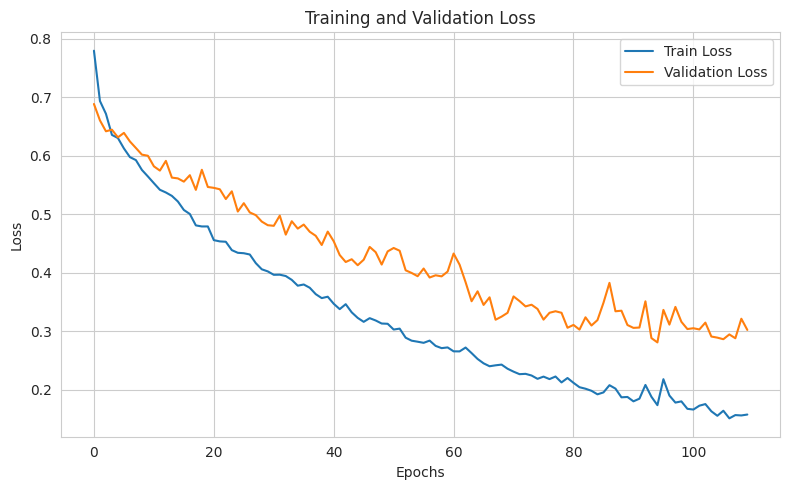

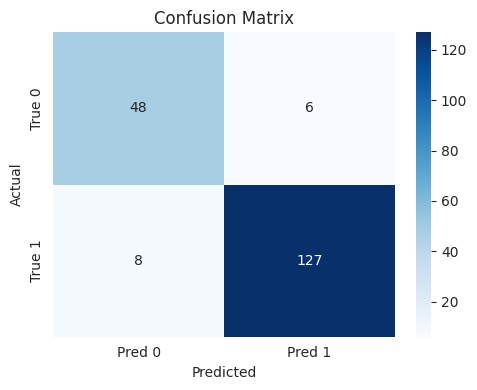

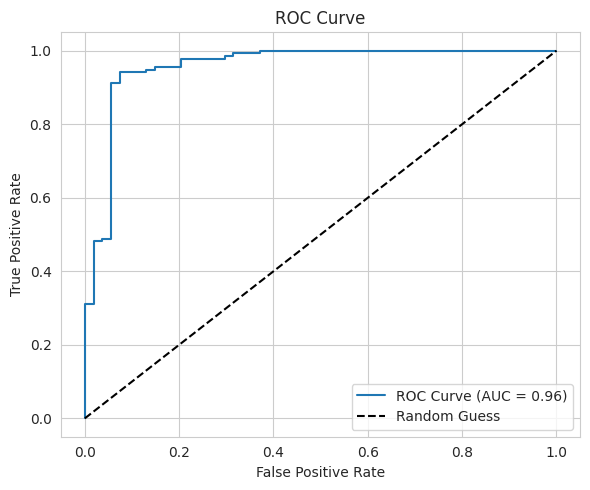

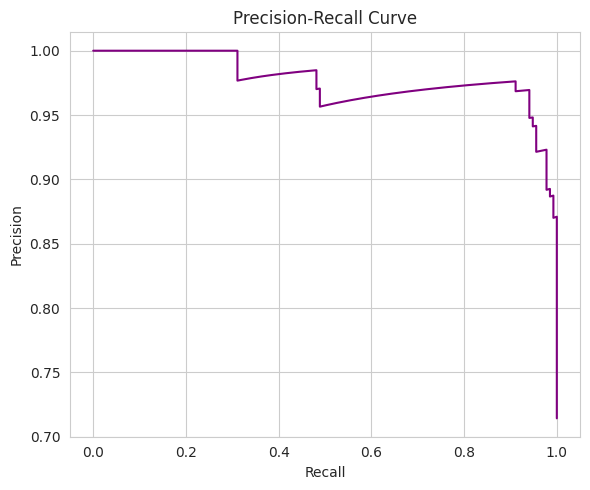

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.float32).unsqueeze(1)

# Dataset and DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train_pca.shape[1], 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Linear(150, 75),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Linear(75, 25),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            nn.Linear(25, 5),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training with early stopping
patience = 15
best_loss = float('inf')
epochs_no_improve = 0
n_epochs = 600

train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
with torch.no_grad():
    test_preds_prob = model(X_test_tensor.to(device)).cpu().numpy()
    test_preds = (test_preds_prob > 0.5).astype(int)
    y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, test_preds)
precision = precision_score(y_true, test_preds)
recall = recall_score(y_true, test_preds)
f1 = f1_score(y_true, test_preds)
roc_auc = roc_auc_score(y_true, test_preds_prob)

print(f"\n✅ Final Test Metrics:")
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# --- 🔍 Visualization Section ---

# 1. Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_true, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_true, test_preds_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_true, test_preds_prob)
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Convert to numpy arrays if needed
X_train_np = np.array(X_train_pca)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test_pca)
y_test_np = np.array(y_test)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_np, y_train_np)

y_pred = model.predict(X_test_np)
y_pred_prob = model.predict_proba(X_test_np)[:, 1]

print("Accuracy:", accuracy_score(y_test_np, y_pred))
print("Precision:", precision_score(y_test_np, y_pred))
print("Recall:", recall_score(y_test_np, y_pred))
print("F1-score:", f1_score(y_test_np, y_pred))
print("ROC AUC:", roc_auc_score(y_test_np, y_pred_prob))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8571428571428571
Precision: 0.8506493506493507
Recall: 0.9703703703703703
F1-score: 0.9065743944636678
ROC AUC: 0.909190672153635


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# ✅ Ensure y_train and y_test are numpy arrays
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.float32).unsqueeze(1)

# Dataset and DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

class ImprovedANN(nn.Module):
    def __init__(self):
        super(ImprovedANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train_pca.shape[1], 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(150, 75),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(75, 25),
            nn.BatchNorm1d(25),
            nn.ReLU(),

            nn.Linear(25, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)


# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedANN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping settings
patience = 15
best_loss = float('inf')
epochs_no_improve = 0
n_epochs = 600

# Training loop with early stopping
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set with more metrics
with torch.no_grad():
    test_preds_prob = model(X_test_tensor.to(device)).cpu().numpy()
    test_preds = (test_preds_prob > 0.5).astype(int)
    y_true = y_test_tensor.numpy()

    accuracy = accuracy_score(y_true, test_preds)
    precision = precision_score(y_true, test_preds)
    recall = recall_score(y_true, test_preds)
    f1 = f1_score(y_true, test_preds)

    # ROC AUC requires probabilities and binary labels
    roc_auc = roc_auc_score(y_true, test_preds_prob)

    print(f"\n✅ Final Test Metrics:")
    print(f"Accuracy:  {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")



Epoch 1/600, Train Loss: 0.6677, Val Loss: 0.6498
Epoch 2/600, Train Loss: 0.5719, Val Loss: 0.5440
Epoch 3/600, Train Loss: 0.4932, Val Loss: 0.4910
Epoch 4/600, Train Loss: 0.4601, Val Loss: 0.4600
Epoch 5/600, Train Loss: 0.4163, Val Loss: 0.4302
Epoch 6/600, Train Loss: 0.3772, Val Loss: 0.4110
Epoch 7/600, Train Loss: 0.3442, Val Loss: 0.3856
Epoch 8/600, Train Loss: 0.3174, Val Loss: 0.3637
Epoch 9/600, Train Loss: 0.3128, Val Loss: 0.3475
Epoch 10/600, Train Loss: 0.2841, Val Loss: 0.3356
Epoch 11/600, Train Loss: 0.2579, Val Loss: 0.3340
Epoch 12/600, Train Loss: 0.2624, Val Loss: 0.3246
Epoch 13/600, Train Loss: 0.2386, Val Loss: 0.3230
Epoch 14/600, Train Loss: 0.2367, Val Loss: 0.3076
Epoch 15/600, Train Loss: 0.2158, Val Loss: 0.3118
Epoch 16/600, Train Loss: 0.2037, Val Loss: 0.2916
Epoch 17/600, Train Loss: 0.2200, Val Loss: 0.2813
Epoch 18/600, Train Loss: 0.1823, Val Loss: 0.2904
Epoch 19/600, Train Loss: 0.1936, Val Loss: 0.2870
Epoch 20/600, Train Loss: 0.1592, Val Lo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=8, num_layers=2, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        # Automatically find largest divisor <= 8
        def find_largest_divisor(n, max_div=8):
            for i in reversed(range(1, max_div+1)):
                if n % i == 0:
                    return i
            return 1

        self.seq_len = find_largest_divisor(feature_dim, max_div=8)
        print(f"Using seq_len={self.seq_len} for feature_dim={feature_dim}")

        self.token_dim = feature_dim // self.seq_len

        self.embedding = nn.Linear(self.token_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )


    def forward(self, x):
        # x shape: (batch_size, feature_dim)
        batch_size = x.size(0)
        x = x.view(batch_size, self.seq_len, self.token_dim)  # (batch_size, seq_len, token_dim)

        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = self.pos_encoder(x)  # add positional encoding

        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model) for transformer
        x = self.transformer_encoder(x)  # (seq_len, batch_size, d_model)

        x = x.mean(dim=0)  # average over seq_len -> (batch_size, d_model)

        x = self.classifier(x)  # (batch_size, 1)
        x = torch.sigmoid(x)    # for BCE loss compatibility

        return x

# Replace your model creation with this
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(feature_dim=X_train_pca.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Rest of your training loop remains the same:
# - train_loader, val_loader etc.
# - early stopping
# - evaluation metrics

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor.to(device))  # raw outputs before sigmoid
    probs = torch.sigmoid(logits).cpu().numpy()  # convert to probabilities
    preds = (probs > 0.5).astype(int)  # binary predictions
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, preds)
precision = precision_score(y_true, preds)
recall = recall_score(y_true, preds)
f1 = f1_score(y_true, preds)
roc_auc = roc_auc_score(y_true, probs)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")




Using seq_len=5 for feature_dim=55
Accuracy: 71.43%
Precision: 0.7143
Recall: 1.0000
F1-score: 0.8333
ROC AUC: 0.5937


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import math

# PositionalEncoding & TransformerClassifier as you wrote
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=8, num_layers=2, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        # Automatically find largest divisor <= 8
        def find_largest_divisor(n, max_div=8):
            for i in reversed(range(1, max_div+1)):
                if n % i == 0:
                    return i
            return 1

        self.seq_len = find_largest_divisor(feature_dim, max_div=8)
        print(f"Using seq_len={self.seq_len} for feature_dim={feature_dim}")

        self.token_dim = feature_dim // self.seq_len

        self.embedding = nn.Linear(self.token_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.seq_len, self.token_dim)  # (batch_size, seq_len, token_dim)
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = self.pos_encoder(x)  # add positional encoding
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x)  # (seq_len, batch_size, d_model)
        x = x.mean(dim=0)  # average over seq_len -> (batch_size, d_model)
        x = self.classifier(x)  # (batch_size, 1)
        x = torch.sigmoid(x)    # for BCE loss compatibility
        return x


# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(feature_dim=X_train_pca.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, train_loader, val_loader exist

patience = 15
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs = 600

# === Training loop with early stopping ===
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_transformer_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# === Load best model and evaluate ===
model.load_state_dict(torch.load('best_transformer_model.pth'))
model.eval()

with torch.no_grad():
    probs = model(X_test_tensor.to(device)).cpu().numpy()
    preds = (probs > 0.5).astype(int)
    y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, preds)
precision = precision_score(y_true, preds)
recall = recall_score(y_true, preds)
f1 = f1_score(y_true, preds)
roc_auc = roc_auc_score(y_true, probs)

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Using seq_len=5 for feature_dim=55


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/600 | Train Loss: 0.5959 | Val Loss: 0.5985
Epoch 2/600 | Train Loss: 0.5315 | Val Loss: 0.5086
Epoch 3/600 | Train Loss: 0.4644 | Val Loss: 0.4586
Epoch 4/600 | Train Loss: 0.4122 | Val Loss: 0.4387
Epoch 5/600 | Train Loss: 0.3819 | Val Loss: 0.4598
Epoch 6/600 | Train Loss: 0.3612 | Val Loss: 0.4723
Epoch 7/600 | Train Loss: 0.3589 | Val Loss: 0.4430
Epoch 8/600 | Train Loss: 0.3240 | Val Loss: 0.4505
Epoch 9/600 | Train Loss: 0.3119 | Val Loss: 0.4868
Epoch 10/600 | Train Loss: 0.3035 | Val Loss: 0.5485
Epoch 11/600 | Train Loss: 0.3070 | Val Loss: 0.4619
Epoch 12/600 | Train Loss: 0.2837 | Val Loss: 0.5061
Epoch 13/600 | Train Loss: 0.2793 | Val Loss: 0.4882
Epoch 14/600 | Train Loss: 0.2607 | Val Loss: 0.5095
Epoch 15/600 | Train Loss: 0.2368 | Val Loss: 0.5223
Epoch 16/600 | Train Loss: 0.2409 | Val Loss: 0.4804
Epoch 17/600 | Train Loss: 0.2310 | Val Loss: 0.5694
Epoch 18/600 | Train Loss: 0.2437 | Val Loss: 0.6902
Epoch 19/600 | Train Loss: 0.2587 | Val Loss: 0.4365
Ep

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class DeepTransformerClassifier(nn.Module):
    def __init__(self, feature_dim, d_model=128, nhead=8, num_layers=4, dropout=0.2):
        super().__init__()
        def find_divisor(n):
            for i in reversed(range(1, 17)):
                if n % i == 0:
                    return i
            return 1

        self.seq_len = find_divisor(feature_dim)
        self.token_dim = feature_dim // self.seq_len

        self.embedding = nn.Linear(self.token_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.seq_len, self.token_dim)
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return torch.sigmoid(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepTransformerClassifier(feature_dim=X_train_pca.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training settings
n_epochs = 300
patience = 50
best_loss = float('inf')
epochs_no_improve = 0
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "deep_transformer_best.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("✅ Early stopping triggered.")
            break

# Evaluation
model.load_state_dict(torch.load("deep_transformer_best.pth"))
model.eval()
with torch.no_grad():
    probs = model(X_test_tensor.to(device)).cpu().numpy()
    preds = (probs > 0.5).astype(int)
y_true = y_test_tensor.numpy()

print("\n📊 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_true, preds) * 100:.2f}%")
print(f"Precision: {precision_score(y_true, preds):.4f}")
print(f"Recall:    {recall_score(y_true, preds):.4f}")
print(f"F1 Score:  {f1_score(y_true, preds):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_true, probs):.4f}")


Epoch 1/300, Train Loss: 0.5640, Val Loss: 0.5862
Epoch 2/300, Train Loss: 0.5319, Val Loss: 0.5265
Epoch 3/300, Train Loss: 0.5045, Val Loss: 0.5184
Epoch 4/300, Train Loss: 0.4825, Val Loss: 0.5066
Epoch 5/300, Train Loss: 0.4706, Val Loss: 0.5007
Epoch 6/300, Train Loss: 0.4773, Val Loss: 0.4968
Epoch 7/300, Train Loss: 0.4534, Val Loss: 0.4929
Epoch 8/300, Train Loss: 0.4528, Val Loss: 0.4923
Epoch 9/300, Train Loss: 0.4309, Val Loss: 0.4847
Epoch 10/300, Train Loss: 0.4237, Val Loss: 0.4825
Epoch 11/300, Train Loss: 0.4087, Val Loss: 0.4877
Epoch 12/300, Train Loss: 0.3805, Val Loss: 0.4792
Epoch 13/300, Train Loss: 0.3807, Val Loss: 0.4827
Epoch 14/300, Train Loss: 0.3762, Val Loss: 0.5023
Epoch 15/300, Train Loss: 0.3631, Val Loss: 0.4877
Epoch 16/300, Train Loss: 0.3580, Val Loss: 0.5020
Epoch 17/300, Train Loss: 0.3338, Val Loss: 0.4835
Epoch 18/300, Train Loss: 0.3186, Val Loss: 0.5032
Epoch 19/300, Train Loss: 0.3046, Val Loss: 0.5283
Epoch 20/300, Train Loss: 0.2873, Val Lo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from transformers import BertModel, BertConfig

# EEG Classifier using tabtransformer
class TabTransformer(nn.Module):
    def __init__(self, feature_dim, hidden_dim=64, nhead=4, num_layers=2):
        super().__init__()
        self.seq_len = 1  # Treat features as one sequence
        self.hidden_dim = hidden_dim

        # Project EEG feature vector to transformer input size
        self.embedding = nn.Linear(feature_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, feature_dim)
        x = self.embedding(x).unsqueeze(1)  # Shape: (batch_size, 1, hidden_dim)
        x = self.transformer_encoder(x)     # (batch_size, 1, hidden_dim)
        x = x.mean(dim=1)                   # (batch_size, hidden_dim)
        return torch.sigmoid(self.classifier(x))


# Utility to determine seq_len and token_dim
def find_divisor(n):
    for i in reversed(range(1, 17)):
        if n % i == 0:
            return i
    return 1

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_dim = X_train_pca.shape[1]
seq_len = find_divisor(feature_dim)
token_dim = feature_dim // seq_len

model = TabTransformer(feature_dim=X_train_pca.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training loop
n_epochs = 300
patience = 50
best_loss = float('inf')
epochs_no_improve = 0
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "eeg_bert_best.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("✅ Early stopping triggered.")
            break

# Evaluation
model.load_state_dict(torch.load("eeg_bert_best.pth"))
model.eval()
with torch.no_grad():
    probs = model(X_test_tensor.to(device)).cpu().numpy()
    preds = (probs > 0.5).astype(int)
y_true = y_test_tensor.numpy()

print("\n📊 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_true, preds) * 100:.2f}%")
print(f"Precision: {precision_score(y_true, preds):.4f}")
print(f"Recall:    {recall_score(y_true, preds):.4f}")
print(f"F1 Score:  {f1_score(y_true, preds):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_true, probs):.4f}")


Epoch 1/300, Train Loss: 0.5956, Val Loss: 0.5553
Epoch 2/300, Train Loss: 0.5230, Val Loss: 0.5242
Epoch 3/300, Train Loss: 0.4836, Val Loss: 0.4995
Epoch 4/300, Train Loss: 0.4651, Val Loss: 0.4796
Epoch 5/300, Train Loss: 0.4403, Val Loss: 0.4660
Epoch 6/300, Train Loss: 0.4235, Val Loss: 0.4534
Epoch 7/300, Train Loss: 0.3987, Val Loss: 0.4404
Epoch 8/300, Train Loss: 0.3927, Val Loss: 0.4308
Epoch 9/300, Train Loss: 0.3799, Val Loss: 0.4202
Epoch 10/300, Train Loss: 0.3569, Val Loss: 0.4084
Epoch 11/300, Train Loss: 0.3435, Val Loss: 0.3960
Epoch 12/300, Train Loss: 0.3260, Val Loss: 0.3850
Epoch 13/300, Train Loss: 0.3126, Val Loss: 0.3782
Epoch 14/300, Train Loss: 0.2962, Val Loss: 0.3718
Epoch 15/300, Train Loss: 0.2944, Val Loss: 0.3657
Epoch 16/300, Train Loss: 0.2837, Val Loss: 0.3568
Epoch 17/300, Train Loss: 0.2604, Val Loss: 0.3614
Epoch 18/300, Train Loss: 0.2618, Val Loss: 0.3595
Epoch 19/300, Train Loss: 0.2398, Val Loss: 0.3487
Epoch 20/300, Train Loss: 0.2239, Val Lo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# CNN Model
class EEG_CNN(nn.Module):
    def __init__(self):
        super(EEG_CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (1,5,11) -> (16,5,11)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (16,2,5)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32,2,5)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (32,1,2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 1 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

# Setup device, model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Reshape inputs (assuming X_train_tensor and X_test_tensor exist)
X_train_tensor = X_train_tensor.view(-1, 1, 5, 11).to(device)
X_test_tensor = X_test_tensor.view(-1, 1, 5, 11).to(device)
y_train_tensor = y_train_tensor.to(device).float()
y_test_tensor = y_test_tensor.to(device).float()

epochs = 10
batch_size = 32

# Simple batch iteration function
def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in get_batches(X_train_tensor, y_train_tensor, batch_size):
        optimizer.zero_grad()
        outputs = model(X_batch)  # keep output shape [batch_size,1]
        loss = criterion(outputs, y_batch)  # y_batch shape [batch_size,1]
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)

    epoch_loss /= len(X_train_tensor)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    probs = model(X_test_tensor).squeeze().cpu().numpy()
    preds = (probs > 0.5).astype(int)
y_true = y_test_tensor.cpu().numpy()

print("\n📊 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_true, preds) * 100:.2f}%")
print(f"Precision: {precision_score(y_true, preds):.4f}")
print(f"Recall:    {recall_score(y_true, preds):.4f}")
print(f"F1 Score:  {f1_score(y_true, preds):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_true, probs):.4f}")


Epoch 1/10, Loss: 0.6178
Epoch 2/10, Loss: 0.5770
Epoch 3/10, Loss: 0.5345
Epoch 4/10, Loss: 0.4965
Epoch 5/10, Loss: 0.4481
Epoch 6/10, Loss: 0.4042
Epoch 7/10, Loss: 0.3563
Epoch 8/10, Loss: 0.3295
Epoch 9/10, Loss: 0.3079
Epoch 10/10, Loss: 0.2817

📊 Evaluation Metrics:
Accuracy:  81.48%
Precision: 0.8571
Recall:    0.8889
F1 Score:  0.8727
ROC AUC:   0.8743


In [27]:
from google.colab import files
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import tensorflow.keras as tk
help(tk)

Help on package tensorflow.keras in tensorflow:

NAME
    tensorflow.keras - DO NOT EDIT.

DESCRIPTION
    This file was autogenerated. Do not edit it by hand,
    since your modifications would be overwritten.

PACKAGE CONTENTS
    activations (package)
    applications (package)
    backend (package)
    callbacks (package)
    config (package)
    constraints (package)
    datasets (package)
    distribution (package)
    dtype_policies (package)
    export (package)
    initializers (package)
    layers (package)
    legacy (package)
    losses (package)
    metrics (package)
    mixed_precision (package)
    models (package)
    ops (package)
    optimizers (package)
    preprocessing (package)
    quantizers (package)
    random (package)
    regularizers (package)
    saving (package)
    tree (package)
    utils (package)
    visualization (package)
    wrappers (package)

VERSION
    3.8.0

FILE
    /usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/__init__.py




In [19]:
from tensorflow.keras import models
help(models)

Help on package keras.api.models in keras.api:

NAME
    keras.api.models - DO NOT EDIT.

DESCRIPTION
    This file was autogenerated. Do not edit it by hand,
    since your modifications would be overwritten.

PACKAGE CONTENTS


FILE
    /usr/local/lib/python3.11/dist-packages/keras/api/models/__init__.py




In [26]:
from tensorflow.keras.layers import Dense,BatchNormalization,ReLU,Dropout,Input,LeakyReLU
from tensorflow.keras import models,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

X_train_np = np.array(X_train_pca, dtype=np.float32)
y_train_np = np.array(y_train, dtype=np.float32)
X_test_np = np.array(X_test_pca, dtype=np.float32)
y_test_np = np.array(y_test, dtype=np.float32)

model=Sequential([
    Input(shape=(X_train_pca.shape[1],)),
    Dense(150),
    BatchNormalization(),
    ReLU(),
    Dense(75),
    BatchNormalization(),
    ReLU(),
    Dense(25),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Dense(5),
    LeakyReLU(),
    BatchNormalization(),
    Dense(1,activation='sigmoid')
])

early=EarlyStopping(patience=15,monitor='val_loss',restore_best_weights=True,verbose=1)
checkpoint=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True,verbose=1)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_train_np,y_train_np,validation_data=(X_test_np,y_test_np),epochs=100,batch_size=32,callbacks=[early,checkpoint])

# Evaluation
model.load_weights('best_model.h5')
probs = model.predict(X_test_np)
preds = (probs > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test_np, preds)
precision = precision_score(y_test_np, preds)
recall = recall_score(y_test_np, preds)
f1 = f1_score(y_test_np, preds)
roc_auc = roc_auc_score(y_test_np, probs)

print(f"""
✅ Final Test Metrics:
----------------------
Accuracy :  {accuracy * 100:.2f}%
Precision:  {precision:.4f}
Recall   :  {recall:.4f}
F1-Score :  {f1:.4f}
ROC AUC  :  {roc_auc:.4f}
""")

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5684 - loss: 0.7611
Epoch 1: val_loss improved from inf to 0.56426, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - accuracy: 0.5710 - loss: 0.7580 - val_accuracy: 0.7090 - val_loss: 0.5643
Epoch 2/100
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7222 - loss: 0.5312
Epoch 2: val_loss improved from 0.56426 to 0.54185, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7225 - loss: 0.5329 - val_accuracy: 0.7354 - val_loss: 0.5419
Epoch 3/100
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8014 - loss: 0.4737 
Epoch 3: val_loss improved from 0.54185 to 0.52621, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7980 - loss: 0.4782 - val_accuracy: 0.7831 - val_loss: 0.5262
Epoch 4/100
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8106 - loss: 0.4421 
Epoch 4: val_loss improved from 0.52621 to 0.49078, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8124 - loss: 0.4396 - val_accuracy: 0.8201 - val_loss: 0.4908
Epoch 5/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8680 - loss: 0.4053 
Epoch 5: val_loss improved from 0.49078 to 0.47549, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8665 - loss: 0.4062 - val_accuracy: 0.8307 - val_loss: 0.4755
Epoch 6/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8655 - loss: 0.3742 
Epoch 6: val_loss improved from 0.47549 to 0.45573, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8629 - loss: 0.3773 - val_accuracy: 0.8307 - val_loss: 0.4557
Epoch 7/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.3571  
Epoch 7: val_loss improved from 0.45573 to 0.41219, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8682 - loss: 0.3527 - val_accuracy: 0.8466 - val_loss: 0.4122
Epoch 8/100
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8837 - loss: 0.3438 
Epoch 8: val_loss improved from 0.41219 to 0.38315, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8871 - loss: 0.3385 - val_accuracy: 0.8624 - val_loss: 0.3831
Epoch 9/100
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9163 - loss: 0.2803 
Epoch 9: val_loss improved from 0.38315 to 0.35999, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9174 - loss: 0.2816 - val_accuracy: 0.8783 - val_loss: 0.3600
Epoch 10/100
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9408 - loss: 0.2552 
Epoch 10: val_loss improved from 0.35999 to 0.34606, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9389 - loss: 0.2554 - val_accuracy: 0.8783 - val_loss: 0.3461
Epoch 11/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9375 - loss: 0.3172
Epoch 11: val_loss improved from 0.34606 to 0.34110, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9433 - loss: 0.2758 - val_accuracy: 0.8624 - val_loss: 0.3411
Epoch 12/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9375 - loss: 0.2024
Epoch 12: val_loss improved from 0.34110 to 0.30940, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9303 - loss: 0.2302 - val_accuracy: 0.8995 - val_loss: 0.3094
Epoch 13/100
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9481 - loss: 0.2232  
Epoch 13: val_loss improved from 0.30940 to 0.30039, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9490 - loss: 0.2203 - val_accuracy: 0.8995 - val_loss: 0.3004
Epoch 14/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9375 - loss: 0.1813
Epoch 14: val_loss improved from 0.30039 to 0.29452, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.2132 - val_accuracy: 0.8836 - val_loss: 0.2945
Epoch 15/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9688 - loss: 0.1767
Epoch 15: val_loss improved from 0.29452 to 0.28702, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9373 - loss: 0.2025 - val_accuracy: 0.8942 - val_loss: 0.2870
Epoch 16/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.1104
Epoch 16: val_loss improved from 0.28702 to 0.26979, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9655 - loss: 0.1590 - val_accuracy: 0.9153 - val_loss: 0.2698
Epoch 17/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9688 - loss: 0.1643
Epoch 17: val_loss improved from 0.26979 to 0.25983, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9735 - loss: 0.1520 - val_accuracy: 0.9048 - val_loss: 0.2598
Epoch 18/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.1001
Epoch 18: val_loss did not improve from 0.25983
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9657 - loss: 0.1627 - val_accuracy: 0.8889 - val_loss: 0.2672
Epoch 19/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0815
Epoch 19: val_loss did not improve from 0.25983
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9664 - loss: 0.1378 - val_accuracy: 0.8783 - val_loss: 0.2798
Epoch 20/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9375 - loss: 0.1419
Epoch 20: val_loss improved from 0.25983 to 0.24119, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9596 - loss: 0.1428 - val_accuracy: 0.9101 - val_loss: 0.2412
Epoch 21/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9375 - loss: 0.1168
Epoch 21: val_loss improved from 0.24119 to 0.23794, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9652 - loss: 0.1300 - val_accuracy: 0.9312 - val_loss: 0.2379
Epoch 22/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 0.1085
Epoch 22: val_loss did not improve from 0.23794
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9872 - loss: 0.1214 - val_accuracy: 0.9153 - val_loss: 0.2454
Epoch 23/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9688 - loss: 0.1015
Epoch 23: val_loss improved from 0.23794 to 0.23270, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9726 - loss: 0.1156 - val_accuracy: 0.9259 - val_loss: 0.2327
Epoch 24/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.1553
Epoch 24: val_loss did not improve from 0.23270
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9778 - loss: 0.1039 - val_accuracy: 0.8889 - val_loss: 0.2565
Epoch 25/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0964
Epoch 25: val_loss improved from 0.23270 to 0.21684, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9850 - loss: 0.1025 - val_accuracy: 0.9312 - val_loss: 0.2168
Epoch 26/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9688 - loss: 0.0887
Epoch 26: val_loss did not improve from 0.21684
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9715 - loss: 0.0953 - val_accuracy: 0.9153 - val_loss: 0.2367
Epoch 27/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0668
Epoch 27: val_loss did not improve from 0.21684
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9834 - loss: 0.0948 - val_accuracy: 0.8942 - val_loss: 0.2317
Epoch 28/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0511
Epoch 28: val_loss did not improve from 0.21684
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9777 - loss: 0.0891 - val_accuracy: 0.9312 - val_loss: 0.2250
Epoch 29/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0596
Epoch 29: val_loss did not improve from 0.21684

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9957 - loss: 0.0557 - val_accuracy: 0.9259 - val_loss: 0.2096
Epoch 35/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9688 - loss: 0.1138
Epoch 35: val_loss did not improve from 0.20961
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9834 - loss: 0.0767 - val_accuracy: 0.9101 - val_loss: 0.2396
Epoch 36/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9688 - loss: 0.0657
Epoch 36: val_loss did not improve from 0.20961
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9770 - loss: 0.0683 - val_accuracy: 0.8995 - val_loss: 0.2441
Epoch 37/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9688 - loss: 0.0764
Epoch 37: val_loss did not improve from 0.20961
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9880 - loss: 0.0495 - val_accuracy: 0.9259 - val_loss: 0.2270
Epoch 38/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0498
Epoch 38: val_loss did not improve from 0.20961